# Spike density function(PSTH) Plotting

### Load Configs

In [41]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *
from scipy.ndimage import gaussian_filter1d
from config import dir_config, main_config
compiled_dir = Path(dir_config.data.compiled)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load spike data and trial information

In [42]:
session_metadata = pd.read_csv(Path(compiled_dir, "sessions_metadata.csv"), index_col=None)
session_name = '250109_GP_TZ'
sorting_dir = Path(dir_config.data.sorting)
sorting_data_path = Path(sorting_dir,session_name,'kilosort4')

spike_times = np.load(sorting_data_path / "spike_times.npy")
spike_clusters = np.load(sorting_data_path / "spike_clusters.npy")
cluster_info = pd.read_csv(sorting_data_path / "cluster_info.tsv", sep='\t', index_col=False)
# sorted good clusters
good_clusters = cluster_info[cluster_info.group == 'good']

timestamps = pd.read_csv(Path(compiled_dir, session_name,f"{session_name}_timestamps.csv"), index_col=None)
trial_info = pd.read_csv(Path(compiled_dir, session_name,f"{session_name}_trial.csv"), index_col=None)
coherence_levels = np.unique(trial_info.loc[~np.isnan(trial_info['coherence']),'coherence'])



In [59]:
# cluster to show
cluster_to_show = cluster_info.cluster_id
cluster_to_show = cluster_info[cluster_info.group == 'good'].cluster_id
# cluster_to_show = [14]
# cluster_to_show = cluster_info[cluster_info.KSLabel == 'good'].cluster_id

### Utils

In [60]:
# extract spikes aligned to specific event, then smoothened

def spike_train_convolved(cluster_spike_time,timestamps,valid_trial,alignment_settings,alignment_buffer):

    valid_trial_timestamps = timestamps.iloc[valid_trial]
    spike_train = []
    convolved_spike_density = []
    sigma = 10 # 10ms smoothing
    
    for alignment_idx in range(len(alignment_settings)):
        spike_train.append(np.zeros([valid_trial.shape[0], 1 + alignment_settings[alignment_idx]['end_time_ms'] - alignment_settings[alignment_idx]['start_time_ms'] + 2*alignment_buffer]))
        convolved_spike_density.append(np.zeros([valid_trial.shape[0], 1 + alignment_settings[alignment_idx]['end_time_ms'] - alignment_settings[alignment_idx]['start_time_ms'] + 2*alignment_buffer]))

        for idx, trial_id in enumerate(valid_trial):
            start_timestamp = valid_trial_timestamps.loc[trial_id,alignment_settings[alignment_idx]['alignment_event']] + (alignment_settings[alignment_idx]['start_time_ms']-alignment_buffer) * 30 
            end_timestamp = valid_trial_timestamps.loc[trial_id,alignment_settings[alignment_idx]['alignment_event']] + (alignment_settings[alignment_idx]['end_time_ms']+alignment_buffer) *30
            spikes_timestamp = cluster_spike_time[(cluster_spike_time >= start_timestamp) & (cluster_spike_time <= end_timestamp)] - start_timestamp
            spike_train[alignment_idx][idx,np.ceil(spikes_timestamp/30).astype(int)] = 1
            convolved_spike_density[alignment_idx][idx,:] = gaussian_filter1d(spike_train[alignment_idx][idx,:],sigma=sigma,truncate=3) # gaussian smoothened

            if alignment_settings[alignment_idx]['alignment_event'] == 'stimulus_onset':
                if (end_timestamp-alignment_buffer*30) > valid_trial_timestamps.loc[trial_id,'response_onset'] - 50*30:  # exclude spikes after -50ms aligned to saccade
                    pre_saccade_idx = np.ceil((end_timestamp-valid_trial_timestamps.loc[trial_id,'response_onset'] )/30 + 50 - alignment_buffer).astype(int)
                    spike_train[alignment_idx][idx,-pre_saccade_idx:] = np.nan
                    convolved_spike_density[alignment_idx][idx,-pre_saccade_idx:] = np.nan

            
            # elif alignment_settings[alignment_idx]['alignment_event'] == 'response_onset':
            #     if start_timestamp < 
    
        
        spike_train[alignment_idx] = spike_train[alignment_idx][:,alignment_buffer:-alignment_buffer]
        convolved_spike_density[alignment_idx] = convolved_spike_density[alignment_idx][:,alignment_buffer:-alignment_buffer] * 1000
        

    return spike_train,convolved_spike_density

##### PSTH plotting functions

In [61]:

def plot_spike_density_VGS(axs,fig_idx,title,alignment_settings_VGS, VGS_convolved_spike_density, VGS_trial_types, plot_std_VGS):

    for alignment_idx in range(len(alignment_settings_VGS)):
        ax = axs[alignment_idx,fig_idx]

        for trial_type in range(len(VGS_trial_types)):

            trial_number = VGS_trial_types[trial_type]['trial_number']
            linewidth = VGS_trial_types[trial_type]['linewidth']
            linestyle = VGS_trial_types[trial_type]['linestyle']
            color = VGS_trial_types[trial_type]['color']

            x_plot = range(alignment_settings_VGS[alignment_idx]['start_time_ms'], alignment_settings_VGS[alignment_idx]['end_time_ms']+1)
            y_plot = VGS_convolved_spike_density[alignment_idx][trial_number,:].mean(axis=0)
            ax.plot(x_plot,y_plot,color = color, linewidth = linewidth,linestyle = linestyle, label = VGS_trial_types[trial_type]['label'])

            if plot_std_VGS:
                y_err = VGS_convolved_spike_density[alignment_idx][trial_number,:].std(axis=0) / np.sqrt(len(trial_number))
                ax.fill_between(x_plot,y_plot+y_err,y_plot-y_err,alpha = VGS_trial_types[trial_type]['shade_alpha'], edgecolor = color, facecolor = color,linestyle = linestyle)
        
        if fig_idx == 0:
            ax.set_ylabel(alignment_settings_VGS[alignment_idx]['alignment_event'])
        if alignment_idx == 0:
            ax.set_title(title)
        ax.axvline(x = 0,linestyle = '--',color = 'k')
        ax.legend()


In [62]:

def plot_spike_density_GP(axs,fig_idx,title,alignment_settings_GP, GP_convolved_spike_density, coherence_levels, GP_valid_trial_idx, GP_coh_trial_types,plot_std_GP):

    colors = ['#e31a1c','#ff7f00','#33a02c','#1f78b4']


    for alignment_idx in range(len(alignment_settings_GP)):
        ax = axs[alignment_idx,fig_idx]

        for trial_type in range(len(GP_coh_trial_types)):

            trial_number = GP_coh_trial_types[trial_type]['trial_number']
            linewidth = GP_coh_trial_types[trial_type]['linewidth']
            linestyle = GP_coh_trial_types[trial_type]['linestyle']

            for coh_idx in range(len(coherence_levels)):
                if alignment_settings_GP[alignment_idx]['alignment_event'] == 'stimulus_onset':
                    reaction_time = np.nanmedian(trial_info.loc[GP_valid_trial_idx[trial_number[coh_idx]],'reaction_time'])
                    end = np.min([reaction_time-50,alignment_settings_GP[alignment_idx]['end_time_ms']]).astype(int) - alignment_settings_GP[alignment_idx]['start_time_ms'] + 2

                else:
                    end = alignment_settings_GP[alignment_idx]['end_time_ms'] - alignment_settings_GP[alignment_idx]['start_time_ms'] + 2

                x_plot = range(alignment_settings_GP[alignment_idx]['start_time_ms'], alignment_settings_GP[alignment_idx]['end_time_ms']+1)
                y_plot = np.nanmean(GP_convolved_spike_density[alignment_idx][trial_number[coh_idx],:],axis=0)
                y_plot[end:] = np.nan

                if GP_coh_trial_types[trial_type]['label']:
                    ax.plot(x_plot, y_plot,color = colors[coh_idx],linewidth = linewidth,linestyle = linestyle, label = str(coherence_levels[coh_idx]))
                else:
                    ax.plot(x_plot, y_plot,color = colors[coh_idx],linewidth = linewidth,linestyle = linestyle)

                if plot_std_GP:
                    y_err = np.nanstd(GP_convolved_spike_density[alignment_idx][trial_number[coh_idx],:],axis=0) / np.sqrt(len(trial_number[coh_idx]))
                    y_err[end:] = np.nan
                    ax.fill_between(x_plot, y_plot+y_err, y_plot-y_err,alpha = GP_coh_trial_types[trial_type]['shade_alpha'], edgecolor = colors[coh_idx], facecolor = colors[coh_idx],linestyle = linestyle)

        if fig_idx == 0:
            ax.set_ylabel(alignment_settings_GP[alignment_idx]['alignment_event'])
        if alignment_idx == 0:
            ax.set_title(title)
        ax.axvline(x = 0,linestyle = '--',color = 'k')
        ax.legend()




##### Trial Extraction functions

In [63]:
def VGS_to_away(trial_info,VGS_valid_trial_idx):
    #separate toRF trials and awayRF trials in VGS
    toRF_VGS_trials = np.where(trial_info.loc[VGS_valid_trial_idx,'choice'] == 1)[0]
    awayRF_VGS_trials = np.where(trial_info.loc[VGS_valid_trial_idx,'choice'] == 0)[0]

    VGS_trial_types = [
        {'trial_number': toRF_VGS_trials,
        'linewidth': 2,
        'linestyle': '-',
        'color': 'k',
        'label': None,
        'shade_alpha': 0.5},

        {'trial_number': awayRF_VGS_trials,
        'linewidth': 1,
        'linestyle': '--',
        'color': 'k',
        'label': None,
         'shade_alpha': 0},

        ]
    return VGS_trial_types

    

In [64]:
def VGS_pre_post_to_away(trial_info,VGS_valid_trial_idx):
    #separate toRF trials and awayRF trials in pre_GP VGS and post_GP VGS
    GP_start_trial_idx = np.where(trial_info['task_type'] == 1)[0][0]
    GP_end_trial_idx = np.where(trial_info['task_type'] == 1)[0][-1]

    pre_toRF_VGS_trials = np.where((trial_info.loc[VGS_valid_trial_idx,'choice'] == 1) & (VGS_valid_trial_idx < GP_start_trial_idx))[0]
    pre_awayRF_VGS_trials = np.where((trial_info.loc[VGS_valid_trial_idx,'choice'] == 0) & (VGS_valid_trial_idx < GP_start_trial_idx))[0]   
    post_toRF_VGS_trials = np.where((trial_info.loc[VGS_valid_trial_idx,'choice'] == 1) & (VGS_valid_trial_idx > GP_end_trial_idx))[0]
    post_awayRF_VGS_trials = np.where((trial_info.loc[VGS_valid_trial_idx,'choice'] == 0) & (VGS_valid_trial_idx > GP_end_trial_idx))[0]

    VGS_trial_types = [
        {'trial_number': pre_toRF_VGS_trials,
        'linewidth': 2,
        'linestyle': '-',
        'color': [0.5,0.5,0.5],
        'label': 'pre_GP',
        'shade_alpha': 0.5},

        {'trial_number': pre_awayRF_VGS_trials,
        'linewidth': 1,
        'linestyle': '--',
        'color': [0.5,0.5,0.5],
        'label': None,
         'shade_alpha': 0},

         {'trial_number': post_toRF_VGS_trials,
        'linewidth': 2,
         'linestyle': '-',
        'color': 'k',
        'label': 'post_GP',
        'shade_alpha': 0.5},

        {'trial_number': post_awayRF_VGS_trials,
        'linewidth': 1,
        'linestyle': '--',
        'color': 'k',
        'label': None,
        'shade_alpha': 0}
        ]
    
    return VGS_trial_types

    

In [65]:
def GP_to_away(coherence_levels,trial_info, GP_valid_trial_idx):
    #separate toRF/awayRF and different cohrence correct trials in GP
    toRF_GP_coh_trials = []
    awayRF_GP_coh_trials = []
    for coherence in coherence_levels:
        if coherence == 0:
            toRF_GP_coh_trials.append(np.where((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence))[0])
            awayRF_GP_coh_trials.append(np.where((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence))[0])

        else:
            toRF_GP_coh_trials.append(np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1))[0])
            awayRF_GP_coh_trials.append(np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1))[0])

    GP_coh_trial_types = [
    {'trial_number': toRF_GP_coh_trials,
     'linewidth': 2,
     'linestyle': '-',
     'label': True,
     'shade_alpha': 0.6},

     {'trial_number': awayRF_GP_coh_trials,
     'linewidth': 1,
     'linestyle': '--',
     'label': False,
     'shade_alpha': 0.2}
    ]
    return GP_coh_trial_types

In [66]:
def GP_to_equal_unequal(coherence_levels,trial_info, GP_valid_trial_idx):
    #separate baseline/prior and different cohrence correct toRF trials
    equal_GP_coh_trials = []
    unequal_GP_coh_trials = []
    for coherence in coherence_levels:
        if coherence == 0:
            equal_GP_coh_trials.append(np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] == 50))[0])
            unequal_GP_coh_trials.append(np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] != 50))[0])
        else:
            equal_GP_coh_trials.append(np.where((((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] == 50))[0])
            unequal_GP_coh_trials.append(np.where((((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] != 50))[0])

  

    GP_coh_trial_types = [
    {'trial_number': equal_GP_coh_trials,
     'linewidth': 1,
     'linestyle': '-',
     'label': True,
     'shade_alpha': 0},

     {'trial_number': unequal_GP_coh_trials,
     'linewidth': 2.5,
     'linestyle': '-',
     'label': False,
     'shade_alpha': 0}
    ]

    return GP_coh_trial_types

In [67]:
def GP_away_equal_unequal(coherence_levels,trial_info, GP_valid_trial_idx):
    #separate baseline/prior and different cohrence correct awayRF trials
    equal_GP_coh_trials = []
    unequal_GP_coh_trials = []
    for coherence in coherence_levels:
        if coherence == 0:
            equal_GP_coh_trials.append(np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] == 50))[0])
            unequal_GP_coh_trials.append(np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] != 50))[0])
        else:
            equal_GP_coh_trials.append(np.where((((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] == 50))[0])
            unequal_GP_coh_trials.append(np.where((((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] != 50))[0])

  

    GP_coh_trial_types = [
    {'trial_number': equal_GP_coh_trials,
     'linewidth': 0.5,
     'linestyle': '--',
     'label': True,
     'shade_alpha': 0},

     {'trial_number': unequal_GP_coh_trials,
     'linewidth': 1.5,
     'linestyle': '--',
     'label': False,
     'shade_alpha': 0}
    ]

    return GP_coh_trial_types

In [68]:
def GP_to_away_equal(coherence_levels,trial_info, GP_valid_trial_idx):
    #separate toRF/awayRF and different cohrence correct trials in baseline
    toRF_GP_coh_trials = []
    awayRF_GP_coh_trials = []
  
    
    for coherence in coherence_levels:
        if coherence == 0:
            toRF_GP_coh_trials_all = np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] == 50))[0]   
            awayRF_GP_coh_trials_all = np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] == 50))[0]       
            
        else:
            toRF_GP_coh_trials_all = np.where((((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] == 50))[0]
            awayRF_GP_coh_trials_all = np.where((((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] == 50))[0]

        toRF_GP_coh_trials.append(toRF_GP_coh_trials_all)
        awayRF_GP_coh_trials.append(awayRF_GP_coh_trials_all)

    GP_coh_trial_types = [
    {'trial_number': toRF_GP_coh_trials,
     'linewidth': 2,
     'linestyle': '-',
     'label': True,
     'shade_alpha': 0.6},

     {'trial_number': awayRF_GP_coh_trials,
     'linewidth': 1,
     'linestyle': '--',
     'label': False,
     'shade_alpha': 0.2}
    ]

  
    return GP_coh_trial_types

In [69]:
def GP_to_away_unequal(coherence_levels,trial_info, GP_valid_trial_idx):
    #separate toRF/awayRF and different cohrence correct trials in prior
    toRF_GP_coh_trials = []
    awayRF_GP_coh_trials = []

    for coherence in coherence_levels:
        if coherence == 0:
            toRF_GP_coh_trials_all = np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] != 50))[0]      
            awayRF_GP_coh_trials_all = np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] != 50))[0]
          
        else:
            toRF_GP_coh_trials_all = np.where((((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] != 50))[0]
            awayRF_GP_coh_trials_all = np.where((((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] != 50))[0]
            
        toRF_GP_coh_trials.append(toRF_GP_coh_trials_all)
        awayRF_GP_coh_trials.append(awayRF_GP_coh_trials_all)


    GP_coh_trial_types = [
    {'trial_number': toRF_GP_coh_trials,
     'linewidth': 2,
     'linestyle': '-',
     'label': True,
     'shade_alpha': 0.6},

     {'trial_number': awayRF_GP_coh_trials,
     'linewidth': 1,
     'linestyle': '--',
     'label': False,
     'shade_alpha': 0.2}
    ]

  
    return GP_coh_trial_types

In [70]:
def GP_to_away_blocks(coherence_levels,trial_info, GP_valid_trial_idx):
    #separate toRF/awayRF and different cohrence correct trials in first/last 200 equal and first/last 200 unequal

    toRF_GP_coh_trials_first_equal = []
    awayRF_GP_coh_trials_first_equal = []
    toRF_GP_coh_trials_last_equal = []
    awayRF_GP_coh_trials_last_equal = []

    toRF_GP_coh_trials_first_unequal = []
    awayRF_GP_coh_trials_first_unequal = []
    toRF_GP_coh_trials_last_unequal = []
    awayRF_GP_coh_trials_last_unequal = []

    all_GP_trials_equal = np.where(trial_info.loc[GP_valid_trial_idx,'prob_toRF'] == 50)[0]    
    all_GP_trials_unequal = np.where(trial_info.loc[GP_valid_trial_idx,'prob_toRF'] != 50)[0]  

    
    for coherence in coherence_levels:
        if coherence == 0:
            toRF_GP_coh_trials_all_equal = np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] == 50))[0]   
            awayRF_GP_coh_trials_all_equal = np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] == 50))[0]       

            toRF_GP_coh_trials_all_unequal = np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] != 50))[0]      
            awayRF_GP_coh_trials_all_unequal = np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] != 50))[0]
          
            
        else:
            toRF_GP_coh_trials_all_equal = np.where((((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] == 50))[0]
            awayRF_GP_coh_trials_all_equal = np.where((((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] == 50))[0]

            toRF_GP_coh_trials_all_unequal = np.where((((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] != 50))[0]
            awayRF_GP_coh_trials_all_unequal = np.where((((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] != 50))[0]
            

        toRF_GP_coh_trials_first_equal.append(np.intersect1d(toRF_GP_coh_trials_all_equal,all_GP_trials_equal[:200]))
        awayRF_GP_coh_trials_first_equal.append(np.intersect1d(awayRF_GP_coh_trials_all_equal,all_GP_trials_equal[:200]))

        toRF_GP_coh_trials_last_equal.append(np.intersect1d(toRF_GP_coh_trials_all_equal,all_GP_trials_equal[-200:]))
        awayRF_GP_coh_trials_last_equal.append(np.intersect1d(awayRF_GP_coh_trials_all_equal,all_GP_trials_equal[-200:]))

        toRF_GP_coh_trials_first_unequal.append(np.intersect1d(toRF_GP_coh_trials_all_unequal,all_GP_trials_unequal[:200]))
        awayRF_GP_coh_trials_first_unequal.append(np.intersect1d(awayRF_GP_coh_trials_all_unequal,all_GP_trials_unequal[:200]))

        toRF_GP_coh_trials_last_unequal.append(np.intersect1d(toRF_GP_coh_trials_all_unequal,all_GP_trials_unequal[-200:]))
        awayRF_GP_coh_trials_last_unequal.append(np.intersect1d(awayRF_GP_coh_trials_all_unequal,all_GP_trials_unequal[-200:]))

   

    GP_coh_trial_types_first_equal = [
    {'trial_number': toRF_GP_coh_trials_first_equal,
     'linewidth': 2,
     'linestyle': '-',
     'label': True,
     'shade_alpha': 0.6},

     {'trial_number': awayRF_GP_coh_trials_first_equal,
     'linewidth': 1,
     'linestyle': '--',
     'label': False,
     'shade_alpha': 0.2}
    ]

    GP_coh_trial_types_last_equal = [
    {'trial_number': toRF_GP_coh_trials_last_equal,
     'linewidth': 2,
     'linestyle': '-',
     'label': True,
     'shade_alpha': 0.6},

     {'trial_number': awayRF_GP_coh_trials_last_equal,
     'linewidth': 1,
     'linestyle': '--',
     'label': False,
     'shade_alpha': 0.2}
    ]

    GP_coh_trial_types_first_unequal = [
    {'trial_number': toRF_GP_coh_trials_first_unequal,
     'linewidth': 2,
     'linestyle': '-',
     'label': True,
     'shade_alpha': 0.6},

     {'trial_number': awayRF_GP_coh_trials_first_unequal,
     'linewidth': 1,
     'linestyle': '--',
     'label': False,
     'shade_alpha': 0.2}
    ]

    GP_coh_trial_types_last_unequal = [
    {'trial_number': toRF_GP_coh_trials_last_unequal,
     'linewidth': 2,
     'linestyle': '-',
     'label': True,
     'shade_alpha': 0.6},

     {'trial_number': awayRF_GP_coh_trials_last_unequal,
     'linewidth': 1,
     'linestyle': '--',
     'label': False,
     'shade_alpha': 0.2}
    ]

    return GP_coh_trial_types_first_equal,GP_coh_trial_types_last_equal,GP_coh_trial_types_first_unequal,GP_coh_trial_types_last_unequal

### VGS settings

In [71]:
# extract specific VGS trials: valid/correct
VGS_valid_trial_idx = np.where((trial_info['task_type'] == 2) & (trial_info['outcome'] == 1))[0]

# alignment settings for VGS trials
alignment_settings_VGS = [
    {'alignment_event': 'target_onset',
    'start_time_ms': -100,
    'end_time_ms': 300},

    {'alignment_event': 'response_onset',
    'start_time_ms': -300,
    'end_time_ms': 100}]

alignment_buffer = 50 




### GP settings

In [72]:
# extract specific VGS trials: valid
GP_valid_trial_idx = np.where((trial_info['task_type'] == 1) & (trial_info['outcome'] >= 0))[0]

# alignment settings for GP trials
alignment_settings_GP = [
    # {'alignment_event': 'fixation_onset',
    # 'start_time_ms': -400,
    # 'end_time_ms': 100},

    {'alignment_event': 'target_onset',
    'start_time_ms': -200,
    'end_time_ms': 300},

    {'alignment_event': 'stimulus_onset',
    'start_time_ms': -100,
    'end_time_ms': 800},

    {'alignment_event': 'response_onset',
    'start_time_ms': -300,
    'end_time_ms': 50}]

alignment_buffer = 50 




### Plot spike density functions for all clusters

amplitude = np.load(sorting_data_path / "amplitudes.npy")
for cluster_id in cluster_to_show:
    plt.figure(cluster_id+1)
    plt.title(f"cluster {cluster_id}, channel {1+cluster_info.loc[cluster_info['cluster_id'] == cluster_id,'ch'].item()}")
    plt.scatter(spike_times[spike_clusters == cluster_id],amplitude[spike_clusters == cluster_id])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

In [73]:
# trial_types_to_plot = ['VGS_to_away','VGS_pre_post_to_away','GP_to_away','GP_to_equal_unequal','GP_away_equal_unequal','GP_to_away_equal','GP_to_away_unequal','GP_to_away_blocks']



C:\Users\mbasso.NPI-NRB507-XPS\AppData\Local\Temp\ipykernel_38324\1442807436.py:24: RuntimeWarning: Mean of empty slice
  y_plot = np.nanmean(GP_convolved_spike_density[alignment_idx][trial_number[coh_idx],:],axis=0)
c:\Users\mbasso.NPI-NRB507-XPS\.conda\envs\prior-sc\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\mbasso.NPI-NRB507-XPS\AppData\Local\Temp\ipykernel_38324\1442807436.py:24: RuntimeWarning: Mean of empty slice
  y_plot = np.nanmean(GP_convolved_spike_density[alignment_idx][trial_number[coh_idx],:],axis=0)
c:\Users\mbasso.NPI-NRB507-XPS\.conda\envs\prior-sc\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\mbasso.NPI-NRB507-XPS\AppData\Local\Temp\ipykernel_38324\1442807436.py:24: RuntimeWarning: Mean of empty slice
  y_plot = np.na

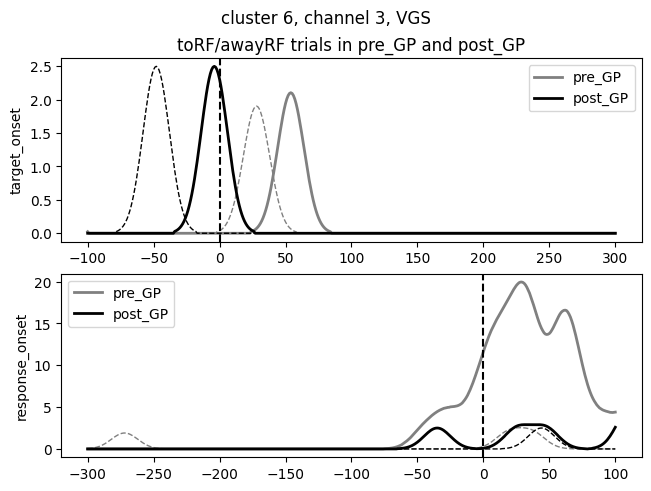

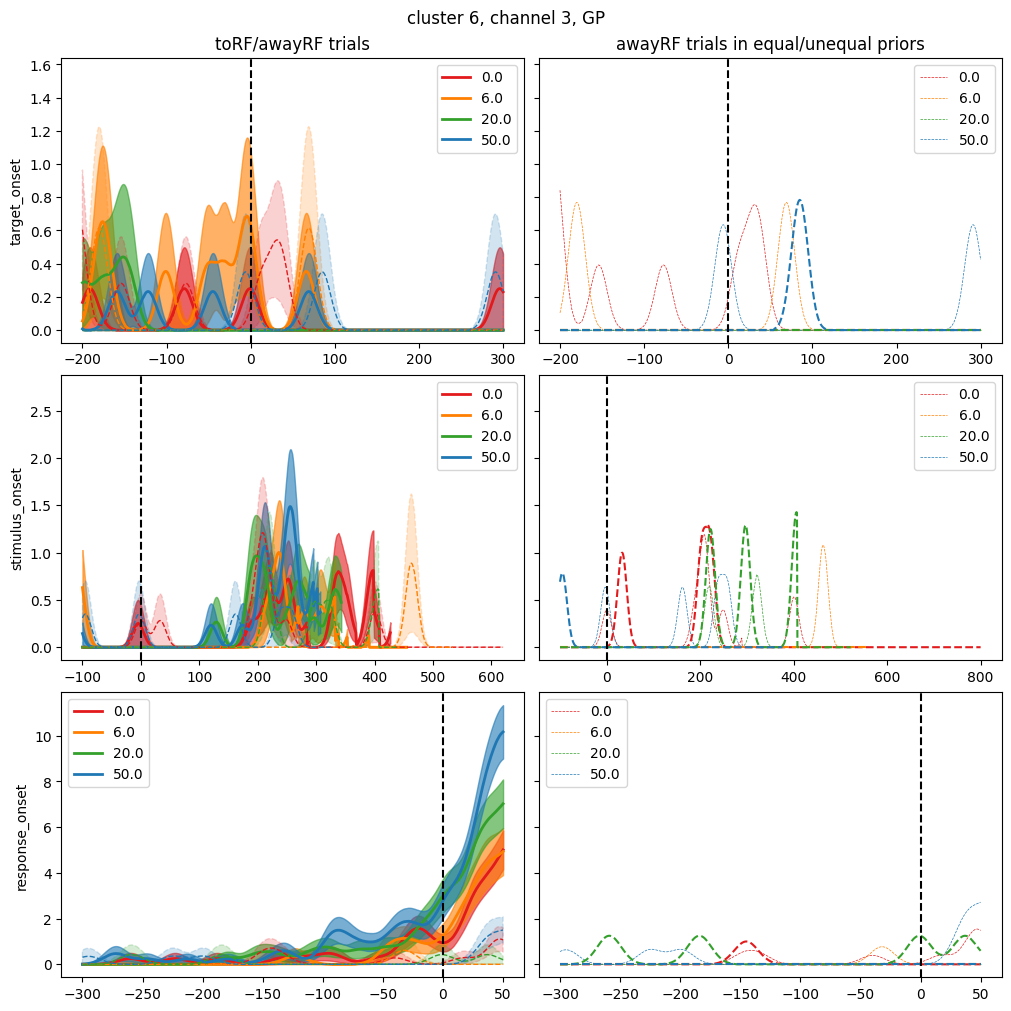

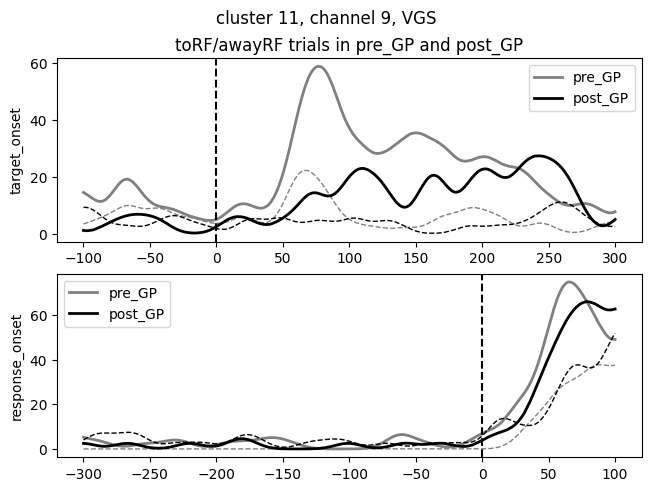

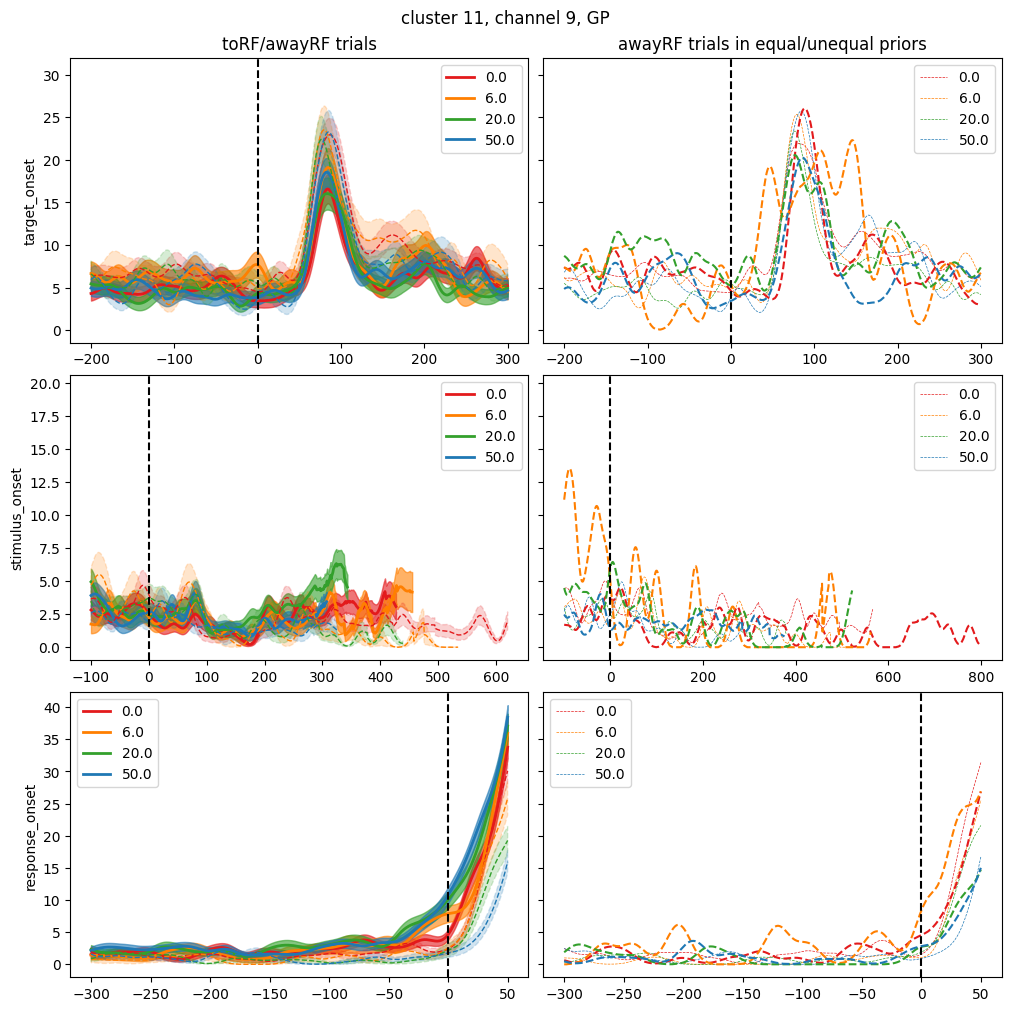

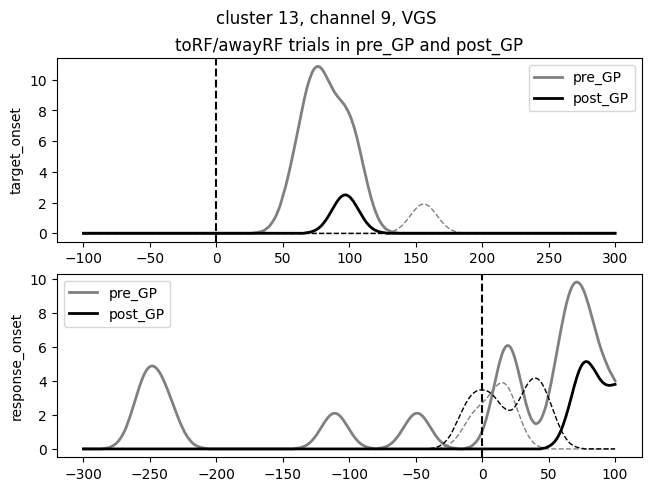

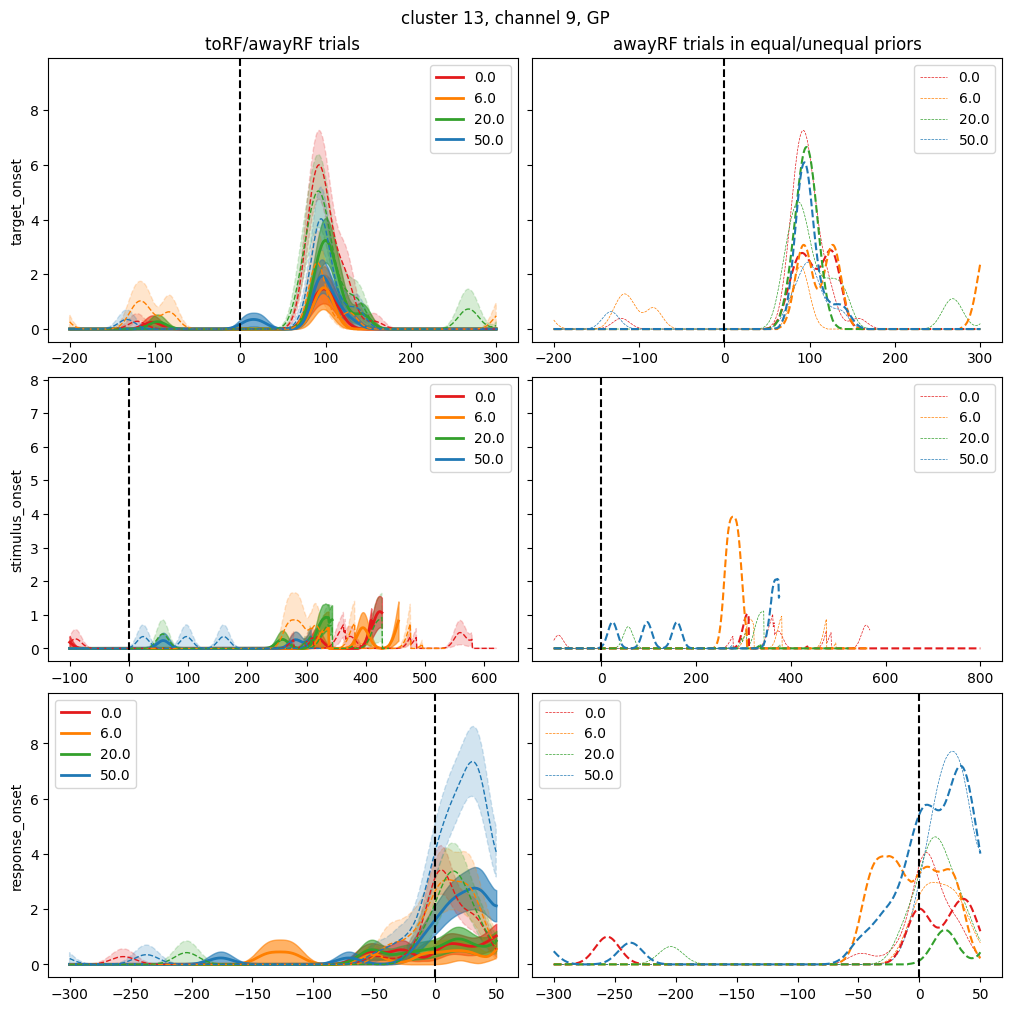

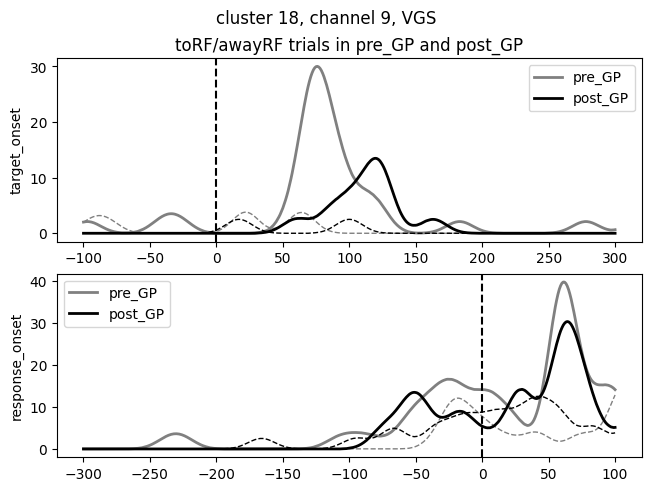

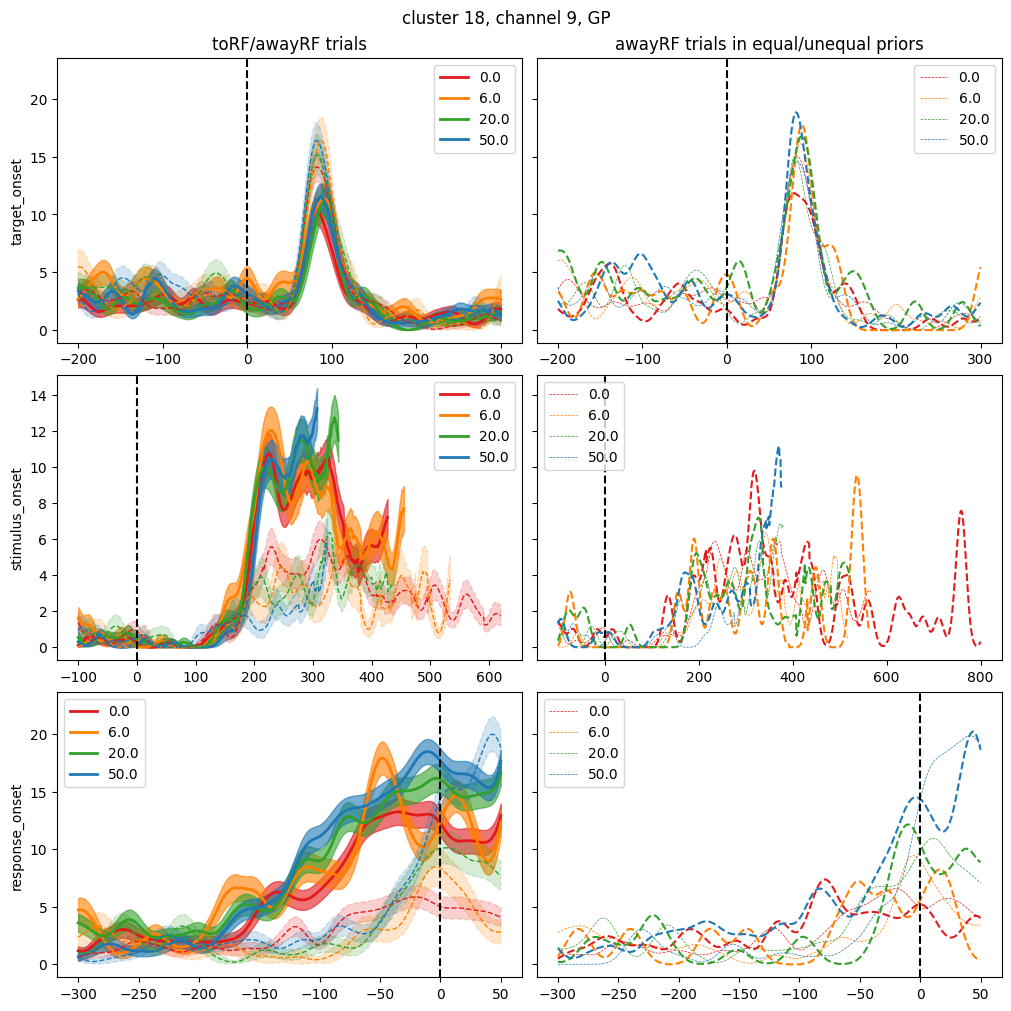

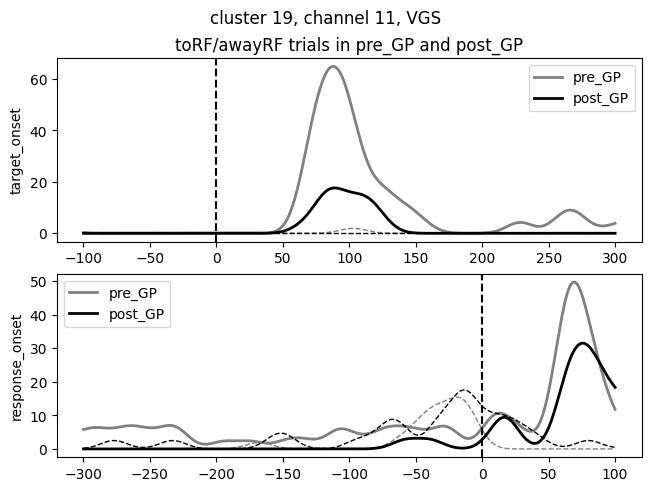

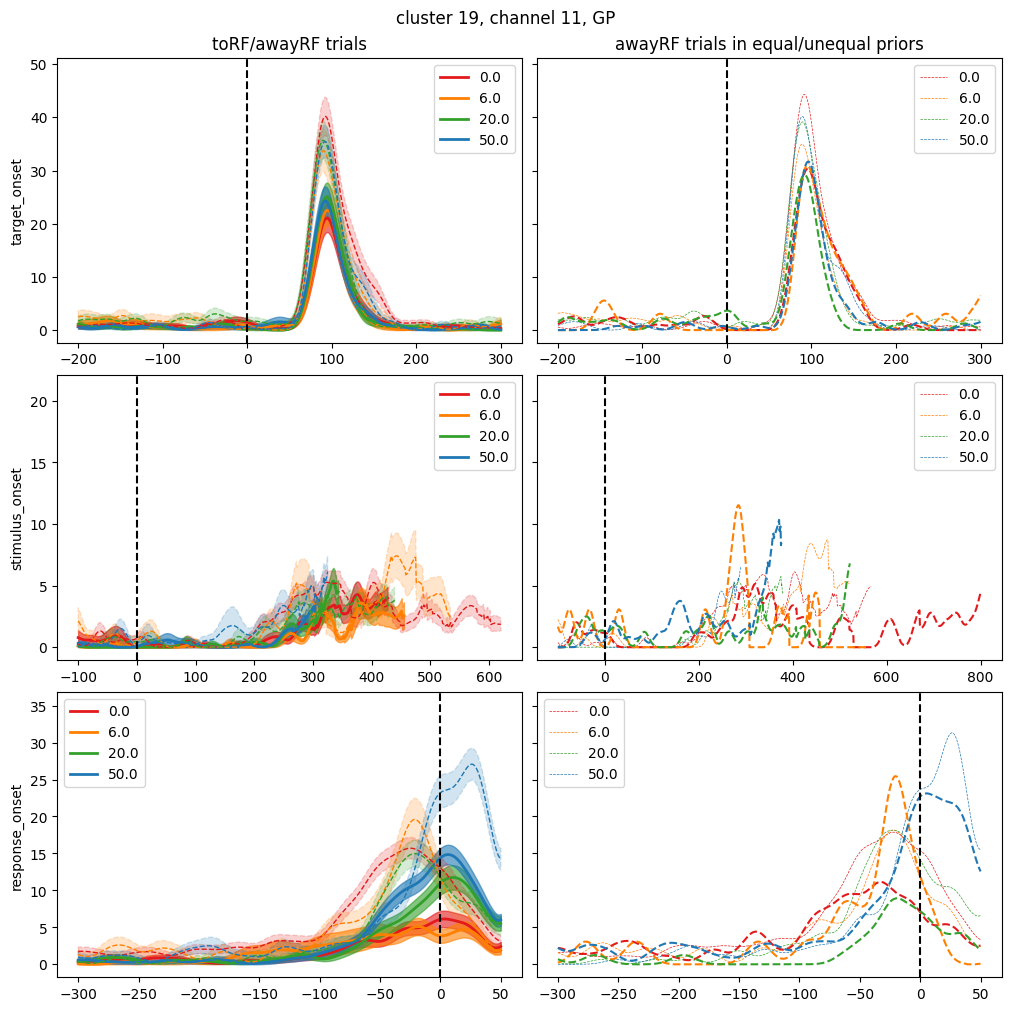

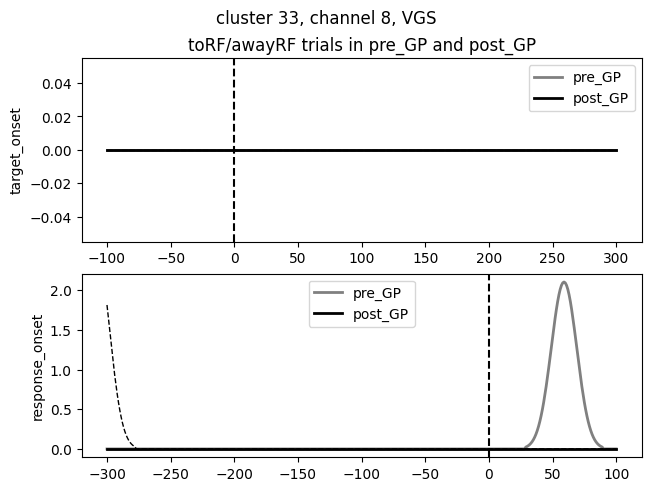

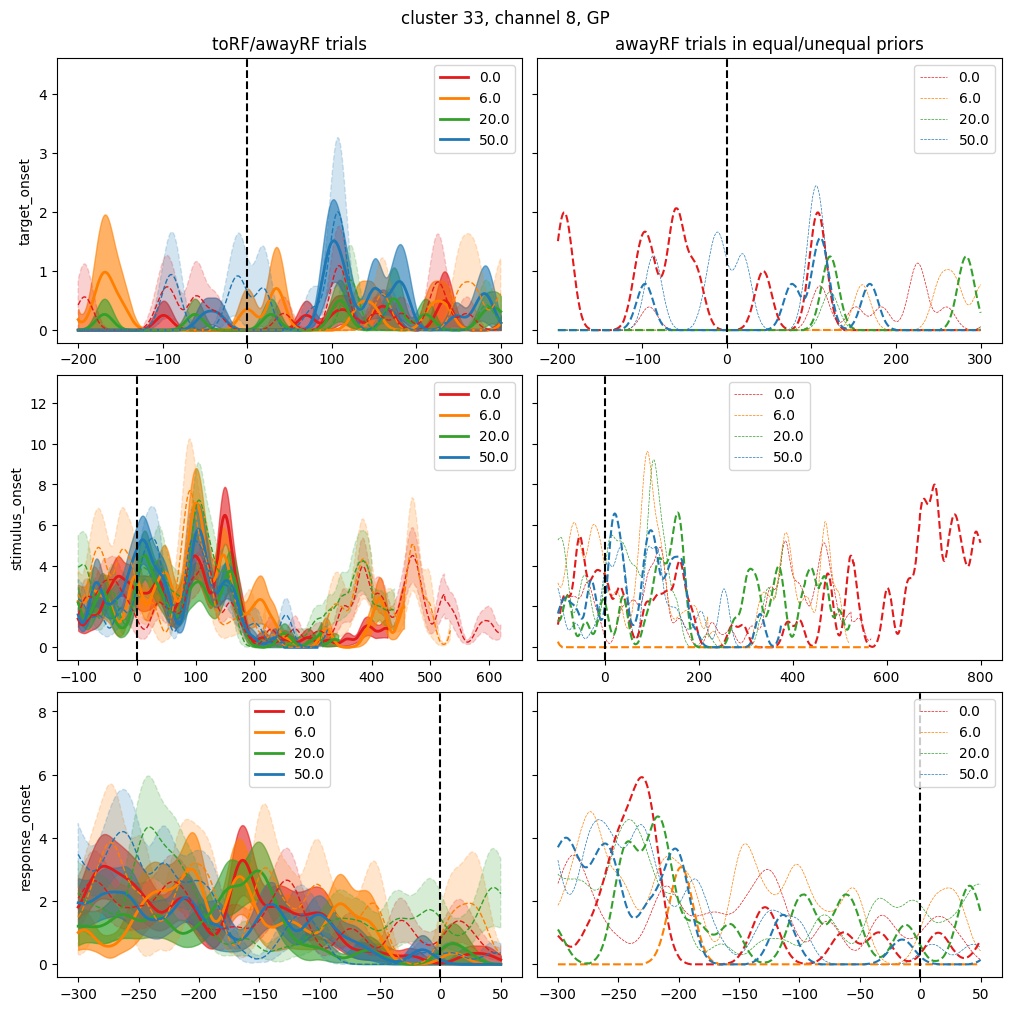

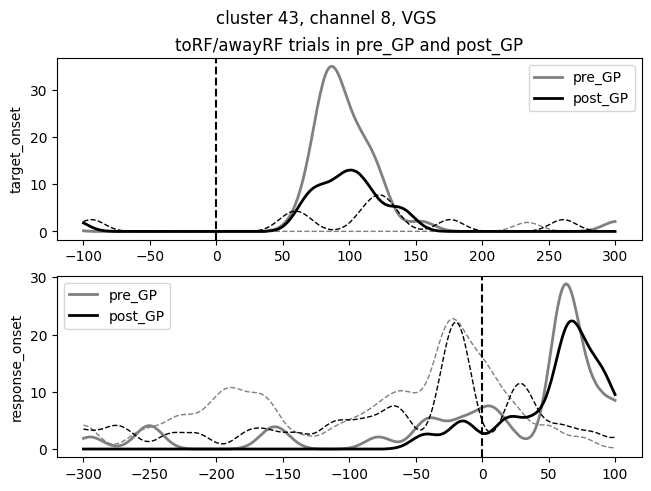

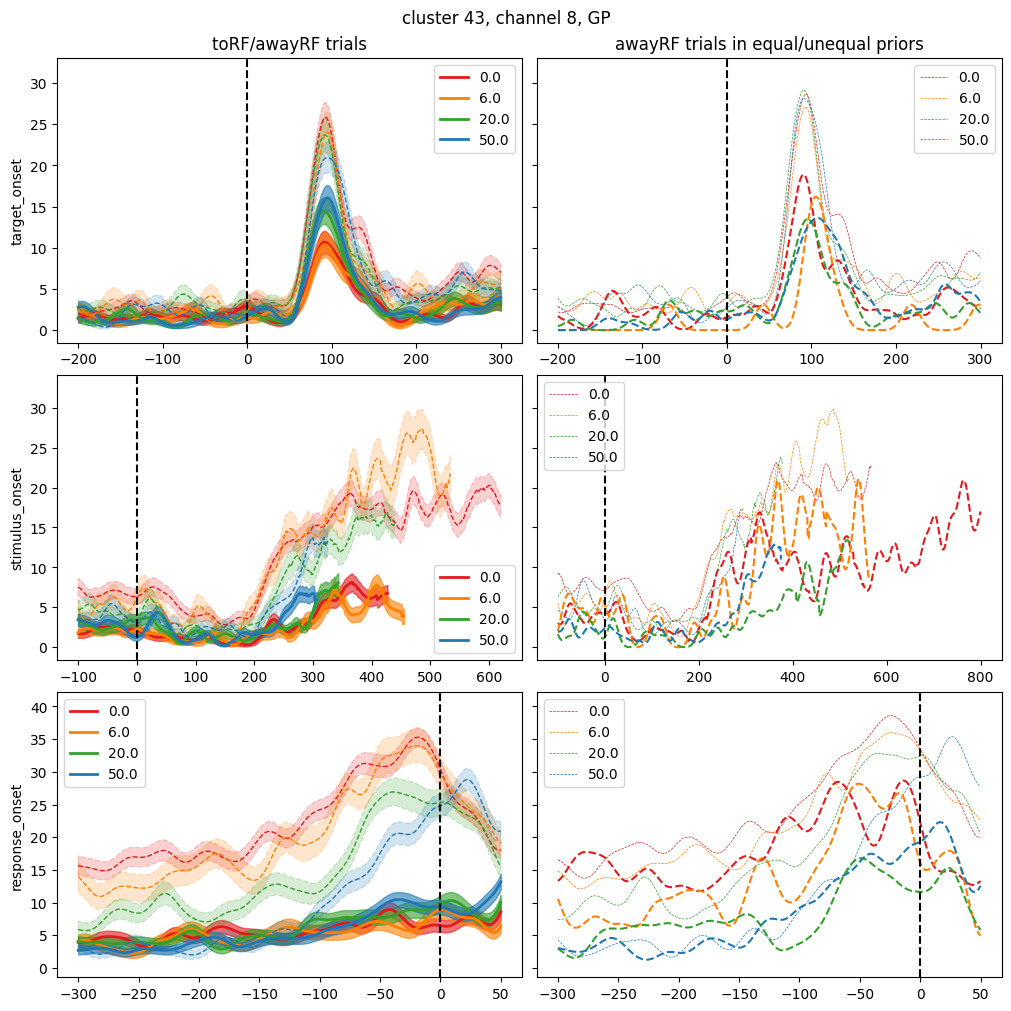

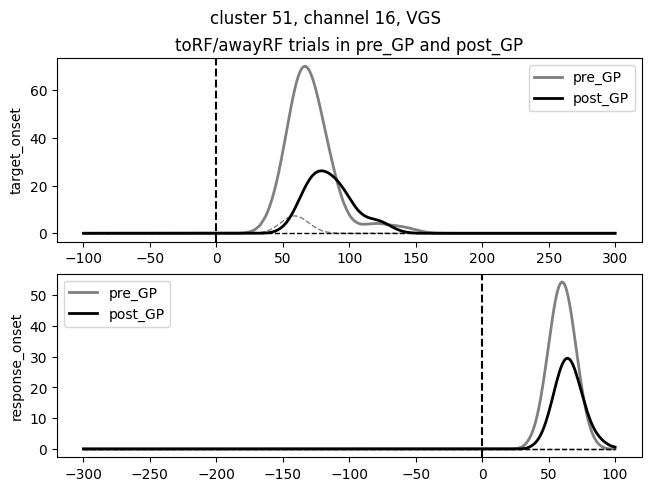

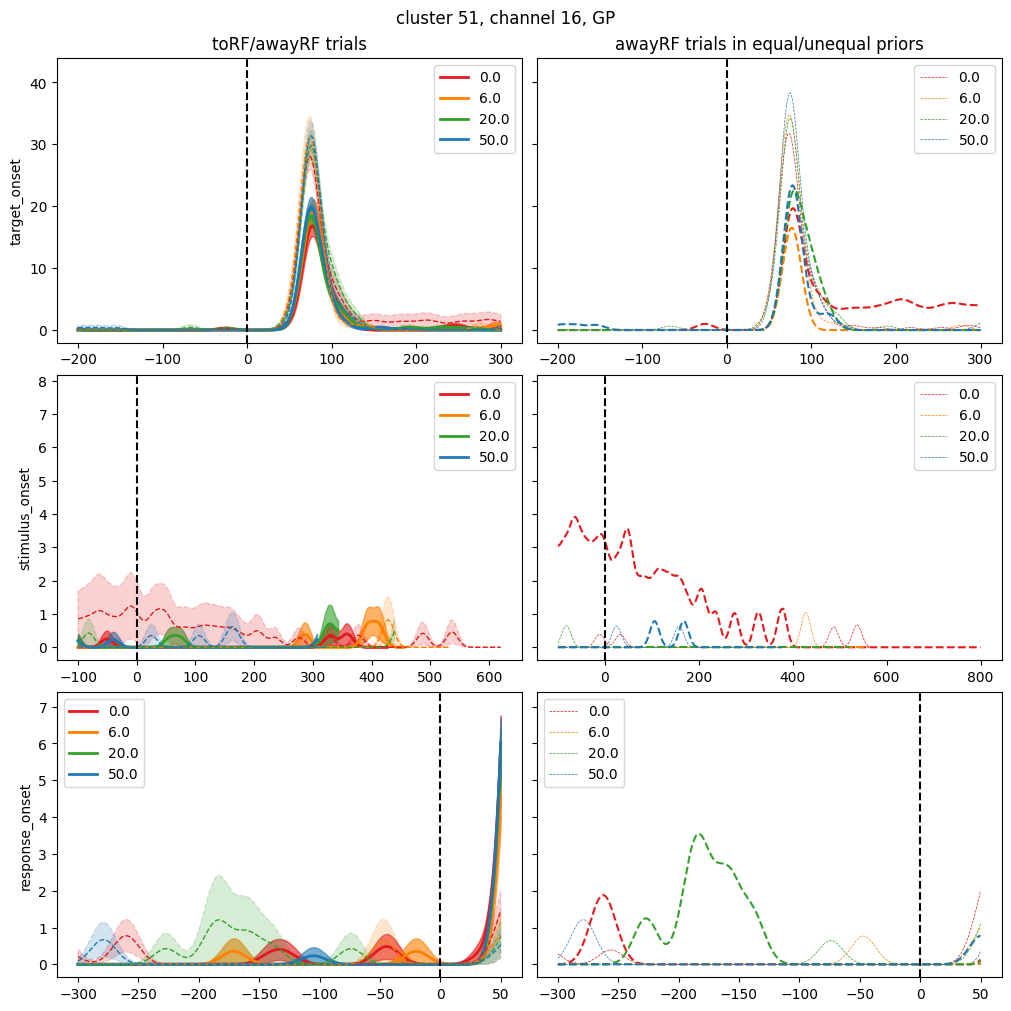

In [76]:
trial_types_to_plot = ['VGS_pre_post_to_away','GP_to_away','GP_away_equal_unequal']

for cluster_id in cluster_to_show :
    cluster_spike_time = spike_times[spike_clusters == cluster_id]
    VGS_spike_train,VGS_convolved_spike_density = spike_train_convolved(cluster_spike_time,timestamps,VGS_valid_trial_idx,alignment_settings_VGS,alignment_buffer)
    GP_spike_train,GP_convolved_spike_density = spike_train_convolved(cluster_spike_time,timestamps,GP_valid_trial_idx,alignment_settings_GP,alignment_buffer)

    if sum([item[:3] == 'VGS' for item in trial_types_to_plot]):
        
        VGS_plots = sum([item[:3] == 'VGS' for item in trial_types_to_plot])
        fig, axs = plt.subplots(len(alignment_settings_VGS), VGS_plots, sharey='row', layout="constrained")
        axs = axs.reshape([len(alignment_settings_VGS), VGS_plots])
        # fig.set_size_inches([15,8])
        fig.suptitle(f"cluster {cluster_id}, channel {1+cluster_info.loc[cluster_info['cluster_id'] == cluster_id,'ch'].item()}, VGS")
        # fig.tight_layout()

        VGS_fig_idx = 0

        if 'VGS_to_away' in trial_types_to_plot:
            VGS_trial_types = VGS_to_away(trial_info,VGS_valid_trial_idx)
            plot_spike_density_VGS(axs,VGS_fig_idx,'toRF/awayRF trials',alignment_settings_VGS, VGS_convolved_spike_density, VGS_trial_types, plot_std_VGS=False)
            VGS_fig_idx = VGS_fig_idx+1

        if 'VGS_pre_post_to_away' in trial_types_to_plot:
            VGS_trial_types = VGS_pre_post_to_away(trial_info,VGS_valid_trial_idx)
            plot_spike_density_VGS(axs,VGS_fig_idx,'toRF/awayRF trials in pre_GP and post_GP',alignment_settings_VGS, VGS_convolved_spike_density, VGS_trial_types, plot_std_VGS=False)
            VGS_fig_idx = VGS_fig_idx+1


    if sum([item[:2] == 'GP' for item in trial_types_to_plot]):

        GP_plots = sum([item[:2] == 'GP' for item in trial_types_to_plot])
        if 'GP_to_away_blocks' in trial_types_to_plot:
            fig, axs = plt.subplots(len(alignment_settings_GP), GP_plots+3, sharey='row', layout="constrained")
        else:
            fig, axs = plt.subplots(len(alignment_settings_GP), GP_plots, sharey='row', layout="constrained")
            axs = axs.reshape([len(alignment_settings_GP), GP_plots])
        fig.set_size_inches([10,10])
        fig.suptitle(f"cluster {cluster_id}, channel {1+cluster_info.loc[cluster_info['cluster_id'] == cluster_id,'ch'].item()}, GP")
        # fig.tight_layout()

        GP_fig_idx = 0

        if 'GP_to_away' in trial_types_to_plot:
            GP_coh_trial_types = GP_to_away(coherence_levels,trial_info, GP_valid_trial_idx)
            plot_spike_density_GP(axs,GP_fig_idx,'toRF/awayRF trials',alignment_settings_GP, GP_convolved_spike_density, coherence_levels, GP_valid_trial_idx, GP_coh_trial_types,plot_std_GP=True)
            GP_fig_idx = GP_fig_idx + 1
           
        if 'GP_to_equal_unequal' in trial_types_to_plot:
            GP_coh_trial_types = GP_to_equal_unequal(coherence_levels,trial_info, GP_valid_trial_idx)
            plot_spike_density_GP(axs,GP_fig_idx,'toRF trials in equal/unequal priors',alignment_settings_GP, GP_convolved_spike_density, coherence_levels, GP_valid_trial_idx, GP_coh_trial_types,plot_std_GP=True)
            GP_fig_idx = GP_fig_idx + 1

        if 'GP_away_equal_unequal' in trial_types_to_plot:
            GP_coh_trial_types = GP_away_equal_unequal(coherence_levels,trial_info, GP_valid_trial_idx)
            plot_spike_density_GP(axs,GP_fig_idx,'awayRF trials in equal/unequal priors',alignment_settings_GP, GP_convolved_spike_density, coherence_levels, GP_valid_trial_idx, GP_coh_trial_types,plot_std_GP=True)
            GP_fig_idx = GP_fig_idx + 1

        if 'GP_to_away_equal' in trial_types_to_plot:
            GP_coh_trial_types = GP_to_away_equal(coherence_levels,trial_info, GP_valid_trial_idx)
            plot_spike_density_GP(axs,GP_fig_idx,'toRF/awayRF trials in equal prior',alignment_settings_GP, GP_convolved_spike_density, coherence_levels, GP_valid_trial_idx, GP_coh_trial_types,plot_std_GP=False)
            GP_fig_idx = GP_fig_idx + 1

        if 'GP_to_away_unequal' in trial_types_to_plot:
            GP_coh_trial_types = GP_to_away_unequal(coherence_levels,trial_info, GP_valid_trial_idx)
            plot_spike_density_GP(axs,GP_fig_idx,'toRF/awayRF trials in unequal prior',alignment_settings_GP, GP_convolved_spike_density, coherence_levels, GP_valid_trial_idx, GP_coh_trial_types,plot_std_GP=False)
            GP_fig_idx = GP_fig_idx + 1

        if 'GP_to_away_blocks' in trial_types_to_plot:
            GP_coh_trial_types_first_equal,GP_coh_trial_types_last_equal,GP_coh_trial_types_first_unequal,GP_coh_trial_types_last_unequal = GP_to_away_blocks(coherence_levels,trial_info, GP_valid_trial_idx)
            
            
            plot_spike_density_GP(axs,GP_fig_idx,'toRF/awayRF trials in first equal prior',alignment_settings_GP, GP_convolved_spike_density, coherence_levels, GP_valid_trial_idx, GP_coh_trial_types_first_equal,plot_std_GP=False)
            GP_fig_idx = GP_fig_idx + 1
            plot_spike_density_GP(axs,GP_fig_idx,'toRF/awayRF trials in last equal prior',alignment_settings_GP, GP_convolved_spike_density, coherence_levels, GP_valid_trial_idx, GP_coh_trial_types_last_equal,plot_std_GP=False)
            GP_fig_idx = GP_fig_idx + 1
            plot_spike_density_GP(axs,GP_fig_idx,'toRF/awayRF trials in first unequal prior',alignment_settings_GP, GP_convolved_spike_density, coherence_levels, GP_valid_trial_idx, GP_coh_trial_types_first_unequal,plot_std_GP=False)
            GP_fig_idx = GP_fig_idx + 1
            plot_spike_density_GP(axs,GP_fig_idx,'toRF/awayRF trials in last unequal prior',alignment_settings_GP, GP_convolved_spike_density, coherence_levels, GP_valid_trial_idx, GP_coh_trial_types_last_unequal,plot_std_GP=False)
            GP_fig_idx = GP_fig_idx + 1


        

